In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn import svm


%matplotlib inline

# load dataset
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
macro = pd.read_csv('./data/macro.csv')

train_no_str = train.select_dtypes(exclude=['object'])
test_no_str = test.select_dtypes(exclude=['object'])


# Outliers/Transformations
Y_train = pd.DataFrame(np.log1p(train['price_doc']).values)
X_train = pd.DataFrame(train.loc[:, train.columns != 'price_doc'].values)
X_test = test.values

In [85]:
missing = train.isnull().agg(np.sum).sort_values()
features = list(missing.index)


# top 20 features with NaN
train.loc[:, features[0:20]]
missing.loc[lambda s: s< 500] != 0

id                             False
market_count_500               False
green_part_1000                False
prom_part_1000                 False
office_count_1000              False
office_sqm_1000                False
trc_count_1000                 False
trc_sqm_1000                   False
cafe_count_1000                False
cafe_count_1000_na_price       False
cafe_count_1000_price_500      False
cafe_count_1000_price_1000     False
cafe_count_1000_price_1500     False
cafe_count_1000_price_2500     False
cafe_count_1000_price_4000     False
sport_count_500                False
cafe_count_1000_price_high     False
church_count_1000              False
mosque_count_1000              False
leisure_count_1000             False
sport_count_1000               False
market_count_1000              False
green_part_1500                False
prom_part_1500                 False
office_count_1500              False
office_sqm_1500                False
trc_count_1500                 False
t

In [23]:
# train.loc[train['build_year'] == 0]
train.loc[train['build_year'] > 2016, ['build_year', 'state']].groupby(['state']).agg(['count'])
# train.loc[train['build_year'] > 2016,].groupby['state']
# train.loc[train['build_year'] <= 215, ['build_year', 'state']].groupby(['state']).agg(['count'])

,build_year
,count
state,
1.0,151
2.0,1
3.0,3
33.0,1


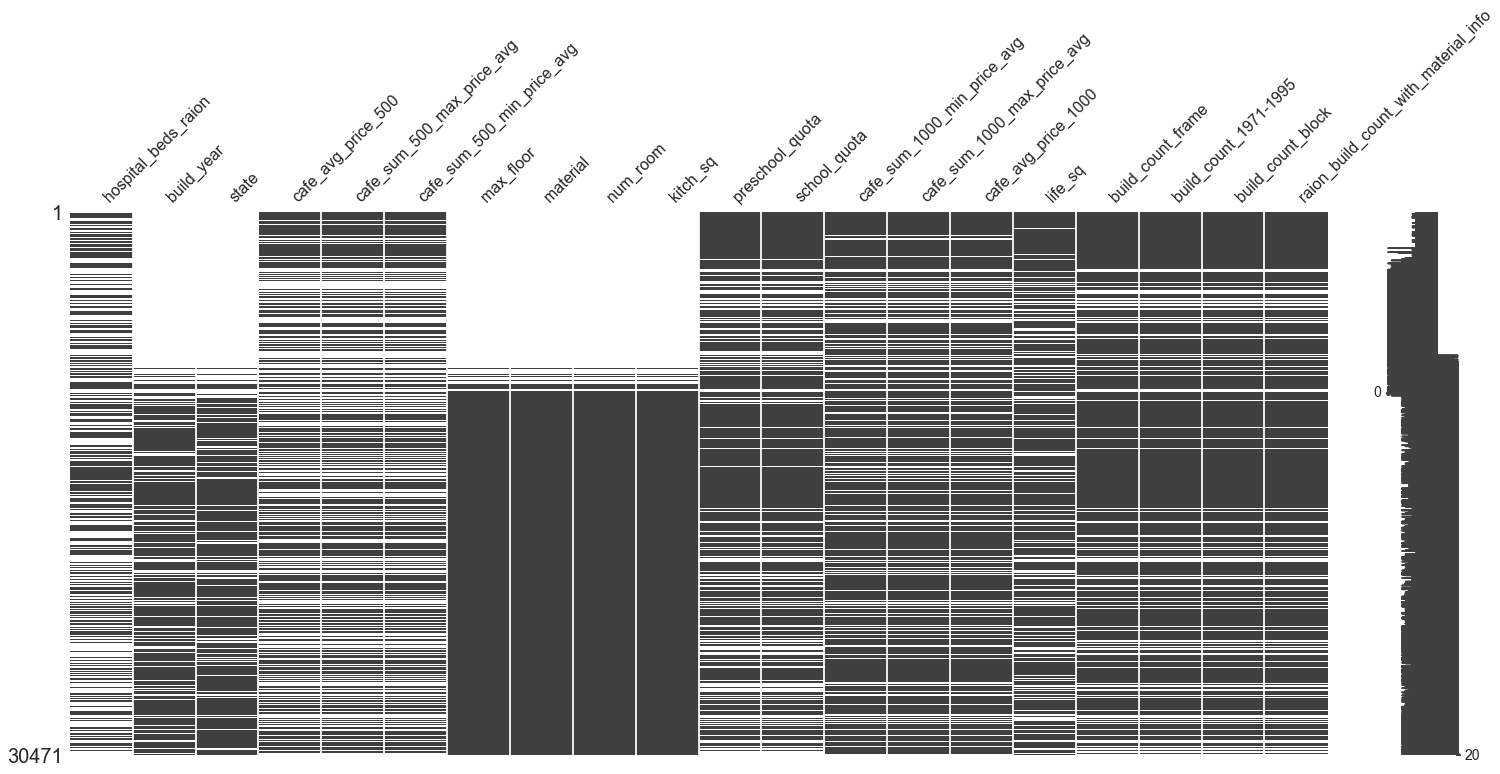

In [66]:
import missingno as msno

msno.missingno.matrix(train.loc[:, features[0:20]])

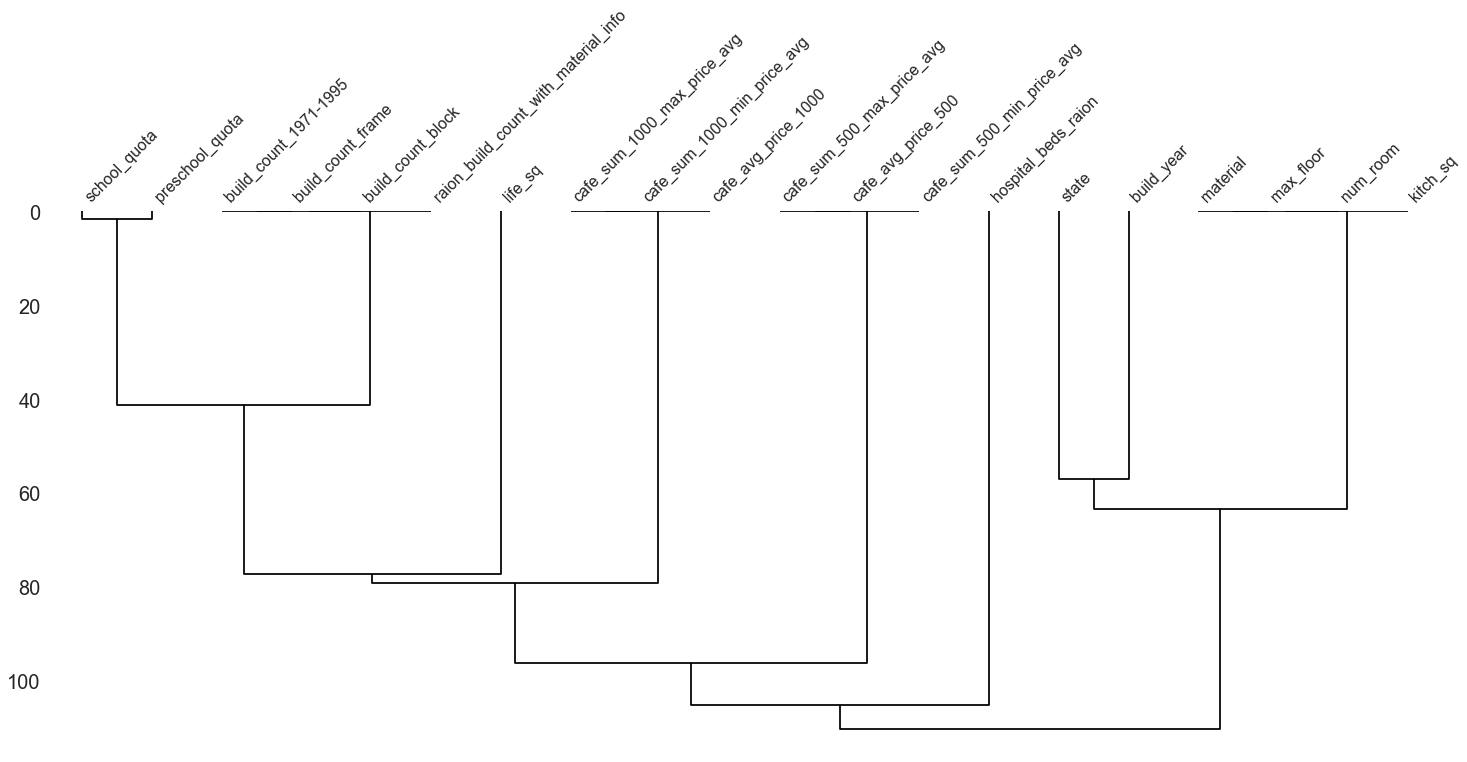

In [68]:
msno.missingno.dendrogram(train.loc[:, features[0:20]])